In [4]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools=tools)

def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router)
graph.add_edge("tool_node", "model")

app = graph.compile()


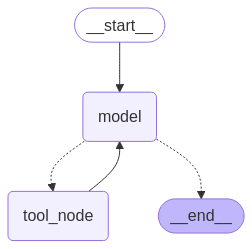

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [7]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])

[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='0fa87a72-ef2d-4084-a0f0-6abb24a91319')]
[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='0fa87a72-ef2d-4084-a0f0-6abb24a91319'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IxhTUoFH83qBla1Kv4m8ruML', 'function': {'arguments': '{"query":"current weather in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1866449

In [8]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x5Yo5tYmif8DBqSoWxaxQ393', 'function': {'arguments': '{"query":"current weather in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7fca5406-6e8a-44a6-a586-f8a0a3553849-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Bangalore'}, 'id': 'call_x5Yo5tYmif8DBqSoWxaxQ393', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 22, 'total_tokens': 108, 'input_t

In [13]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '9f8df4a1-aa65-4bd2-8a31-0bca8171434e', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '2fcaf41c-e494-4806-9e4c-b589da9ddb60', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ('__start__',), 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:b9f9fe35-1986-2a67-1275-6802f72ceba5'}, 'parent_ids': ['9f8df4a1-aa65-4bd2-8a31-0bca8171434e']}
{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': '_write', 'tags': ['seq:step:1', 'langsmith:hidden', 'langsmith:hidden'], 'run_id': 'ca48811c-18b1-4e82-835e-849b47163f16', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ('__start__

In [22]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?